<a href="https://colab.research.google.com/github/jblanco89/MonteCarlo_Portfolio/blob/main/portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycoingecko 

In [2]:
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
import matplotlib.pyplot as plt
import time
import StocksData as sd


Tickers for Portfolio

In [11]:
stocks = ['ltc', 'xmr', 'cake', 'uni', 'sol'] 

In [12]:
prices = sd.get_data(stocks, '09/20/21', '10/08/21')
prices.tail()

,Timestamp,ltc,xmr,cake,uni,sol
425,10/07/21 17:03:49,182.008004,280.307670,19.669761,25.742318,154.988701
426,10/07/21 18:07:14,179.769330,279.161050,19.562878,25.698198,156.266678
427,10/07/21 19:01:52,179.251429,279.430333,19.680328,25.980946,157.221807
428,10/07/21 20:03:12,179.753254,280.142537,19.695377,25.912064,157.750046
429,10/07/21 21:07:44,180.401655,281.333880,19.716058,25.851939,156.268169


In [16]:
#Calculating daily return 
def daily_returns(df):
    return (df.pct_change())

daily_rets = daily_returns(prices.drop('Timestamp', axis=1))

print(daily_rets.tail())



          ltc       xmr      cake       uni       sol
425  0.009764 -0.006495 -0.003812 -0.007837 -0.002442
426 -0.012300 -0.004091 -0.005434 -0.001714  0.008246
427 -0.002881  0.000965  0.006004  0.011003  0.006112
428  0.002800  0.002549  0.000765 -0.002651  0.003360
429  0.003607  0.004253  0.001050 -0.002320 -0.009394


In [17]:
#Setting function for calculting daily return for every selected coin

def mean_return(daily_returns):
    return (daily_returns.mean())

mean_return_rets = mean_return(daily_rets)
print(mean_return_rets.tail())


ltc     0.000120
xmr     0.000242
cake   -0.000251
uni     0.000345
sol     0.000175
dtype: float64


In [18]:
#creating covariance matrices

def covariance_matrix(daily_returns):
    return (daily_returns.cov())

cov_matrix_all = covariance_matrix(daily_rets)
print(cov_matrix_all)

           ltc       xmr      cake       uni       sol
ltc   0.000124 -0.000006 -0.000019 -0.000032 -0.000015
xmr  -0.000006  0.000126  0.000003 -0.000007 -0.000014
cake -0.000019  0.000003  0.000150  0.000167  0.000135
uni  -0.000032 -0.000007  0.000167  0.000300  0.000174
sol  -0.000015 -0.000014  0.000135  0.000174  0.000229


In [21]:
# ------------------------------------------------------
# ------ MONTECARLO SIMULATION FUNCTION ----------------
# ------------------------------------------------------

#we must create a function to calculate returns, standard dev 
# and Sharpe ratios for speciefied randomly weighted portfolios

def results_dataframe(tickers, number_portfolios, mean_daily_returns, cov_matrix):
    results_temp = np.zeros((4 + len(tickers) - 1, number_portfolios))

    for i in range(number_portfolios):
        # select random weights for portfolio holdings
        weights = np.array(np.random.random(len(tickers)))
        
        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # 3 month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139

        # store results in results array
        results_temp[0, i] = portfolio_return
        results_temp[1, i] = portfolio_std_dev
        
        # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
        
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_temp[j + 3, i] = weights[j]

    # convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', tickers[0], 
                                                       tickers[1], tickers[2],
                                                       tickers[3], tickers[4]])
    
    return results_df



In [22]:
results_crypto = results_dataframe(stocks,20000, mean_return_rets, cov_matrix_all)
print(results_crypto.tail())

            ret     stdev    sharpe  ...      cake       uni       sol
19995  0.048400  0.122212  0.282296  ...  0.076516  0.236512  0.184858
19996  0.044912  0.115959  0.267435  ...  0.108323  0.246442  0.097445
19997  0.019173  0.195689  0.026947  ...  0.381691  0.361917  0.170447
19998  0.050302  0.108970  0.334059  ...  0.025955  0.209567  0.157656
19999  0.034243  0.123859  0.164244  ...  0.070184  0.024602  0.397263

[5 rows x 8 columns]


In [23]:
#finding portfolio with the highest sharpe ratio

def max_sr(results_df):
    return results_df.iloc[results_df['sharpe'].idxmax()]

max_sharpe_portfolio = max_sr(results_crypto)
print(max_sharpe_portfolio)


ret       0.058753
stdev     0.111681
sharpe    0.401618
ltc       0.301581
xmr       0.378898
cake      0.004178
uni       0.301745
sol       0.013598
Name: 9062, dtype: float64


In [24]:
#identifiying portfolio with the lowest volatility (stdev)

def min_vol(result_df):
    return result_df.iloc[result_df['stdev'].idxmin()]


In [25]:
min_vol_portfolio = min_vol(result_df=results_crypto)
print(min_vol_portfolio)

ret       0.025643
stdev     0.098566
sharpe    0.119140
ltc       0.389706
xmr       0.327604
cake      0.180532
uni       0.018978
sol       0.083179
Name: 9809, dtype: float64


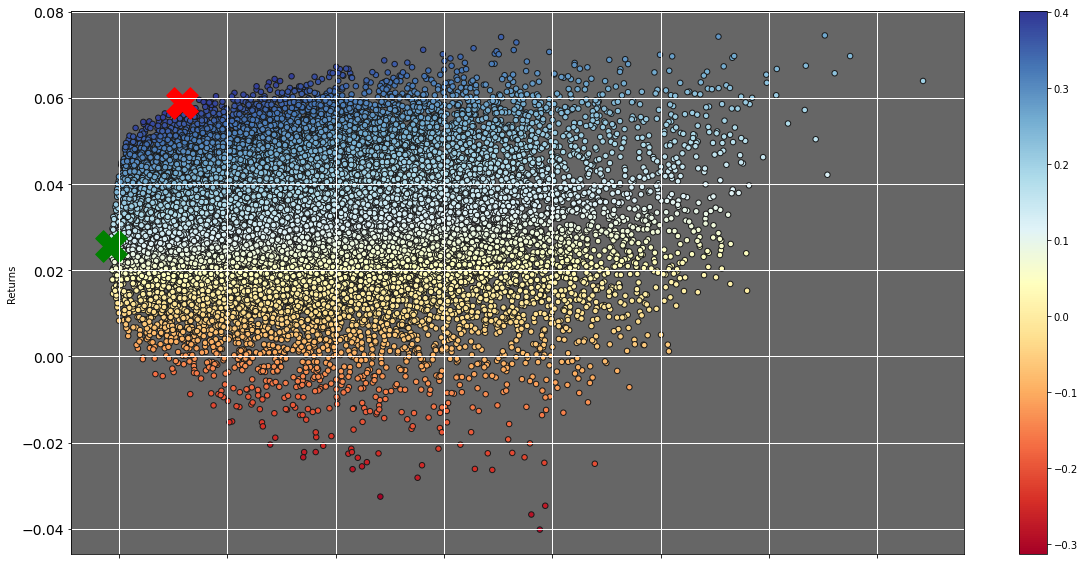

In [26]:
#Plot all different portfolio results with different weights

def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 30, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('0.4')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker="X", color='r', s=1000)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker="X", color='g', s=1000)

plot_graph(results_crypto,max_sharpe_portfolio, min_vol_portfolio)
plt.show()

In [27]:
#Looking for real portfolio weight
real_portfolio = [0.30, 0.25, 0.25, 0.10, 0.10]
type(real_portfolio)

list

In [29]:
rf = results_crypto.iloc[:,[3,4,5,6,7]]
rf

,ltc,xmr,cake,uni,sol
0,0.167031,0.251088,0.183440,0.140675,0.257767
1,0.265163,0.085514,0.174170,0.288073,0.187080
2,0.337917,0.175040,0.153075,0.073482,0.260487
3,0.297278,0.234029,0.299310,0.004652,0.164731
4,0.452071,0.021730,0.090657,0.408674,0.026868
...,...,...,...,...,...
19995,0.197219,0.304895,0.076516,0.236512,0.184858
19996,0.238378,0.309412,0.108323,0.246442,0.097445
19997,0.027961,0.057985,0.381691,0.361917,0.170447
19998,0.332216,0.274606,0.025955,0.209567,0.157656


In [30]:
rf_round = np.round(rf,decimals=2)
rf_round

,ltc,xmr,cake,uni,sol
0,0.17,0.25,0.18,0.14,0.26
1,0.27,0.09,0.17,0.29,0.19
2,0.34,0.18,0.15,0.07,0.26
3,0.30,0.23,0.30,0.00,0.16
4,0.45,0.02,0.09,0.41,0.03
...,...,...,...,...,...
19995,0.20,0.30,0.08,0.24,0.18
19996,0.24,0.31,0.11,0.25,0.10
19997,0.03,0.06,0.38,0.36,0.17
19998,0.33,0.27,0.03,0.21,0.16


In [31]:
rf_round.isin(real_portfolio).any()

ltc     True
xmr     True
cake    True
uni     True
sol     True
dtype: bool

In [34]:

weights = real_portfolio
results_temp = np.zeros((4 + len(stocks) - 1, 1))    
# rebalance weights to sum to 1
weights /= np.sum(weights)

# calculate portfolio return and volatility
portfolio_return = np.sum(mean_return_rets * weights) * 252
portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_all, weights))) * np.sqrt(252)

# 3 month T-Bill yield used as risk free rate of return
risk_free_return = 0.0139

# store results in results array
results_temp[0, 0] = portfolio_return
results_temp[1, 0] = portfolio_std_dev
    
# store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
results_temp[2, 0] = (results_temp[0, 0] - risk_free_return) / results_temp[1, 0]
    
# iterate through the weight vector and add data to results array
for j in range(len(weights)):
  results_temp[j + 3, 0] = weights[j]

# convert results array to Pandas DataFrame
results_test_portfolio = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', stocks[0], 
                                                    stocks[1], stocks[2],
                                                    stocks[3], stocks[4]])

results_test_portfolio


,ret,stdev,sharpe,ltc,xmr,cake,uni,sol
0,0.021583,0.106573,0.072087,0.3,0.25,0.25,0.1,0.1


In [35]:
def plot_graph_test(results_df, max_sharpe_port, min_vol_port, results_test):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 40, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', 
                         figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('0.4')
    ax.set_title("MonteCarlo simulation with real portfolio", fontsize=22, 
                 fontweight='bold')
    ax.set_xlabel('Volatility', fontsize = 14)
    ax.set_ylabel('Returns', fontsize = 14)
    ax.tick_params(labelsize = 14) 

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker="X", color='darkred', s=700)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker="X", color='b', s=700)

    rt = results_test.values

    ax.scatter(rt[0,1], rt[0,0], marker = "X", color = 'k', s=700)




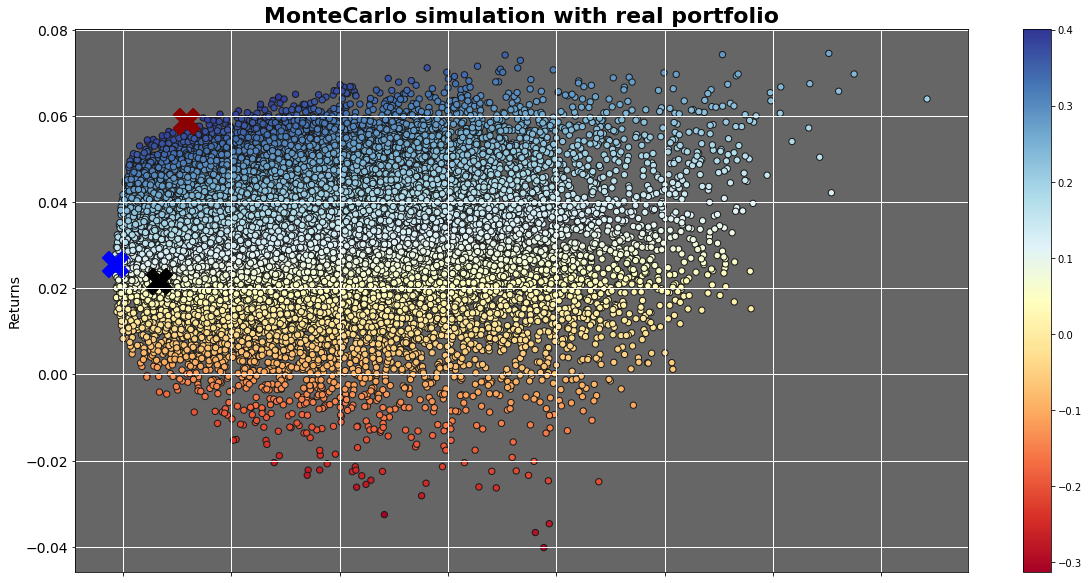

In [36]:
plot_graph_test(results_crypto, max_sharpe_portfolio, min_vol_portfolio, results_test_portfolio)
plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html /content/portfolio.ipynb


[NbConvertApp] Converting notebook /content/portfolio.ipynb to html
[NbConvertApp] Writing 1224186 bytes to /content/portfolio.html
